# Derivativos de Taxa de Juros
## Modelo de Kalotay-Williams-Fabozzi

Renato Mori, Uirá Caiado. 19 de Junho, 2016

**Resumo**

*Neste projeto vamos implementar um modelo de um fator chamado [Kalotay-Williams-Fabozzi](https://en.wikipedia.org/wiki/Short-rate_model#One-factor_short-rate_models), onde apenas um único fator estocástico - a taxa de juros instantânea - determina a evolução de toda estrutura a termo da taxa de juros. Vamos descrever brevemente o modelo, detalhar sua implementação, estimar seus parâmetros e demonstrar sua utilização para precificação de alguns títulos que sejam possíveis de compara com preços de mercado.*

## 1. Introdução

Nesta sessão vamos introduzir o modelo discutido neste trabalho e descrever o problema que será abordado aqui.


### 1.1. Modelagem da Curva de Juros

Como colocado por Fabozzi, a Taxa de Juros frequentemente é modelada usando equações diferenciais estocásticas([SDEs](https://en.wikipedia.org/wiki/Stochastic_differential_equation) é a abreviação em inglês). Os modelos mais comumente utilizados são os modelos de um ou dois fatores (estocástios), sendo que o de um usa uma SDE para representar a taxa de juros de curto prazo e a segunda representa tanto a taxa de curto como a de longo prazo. Na dinâmica escolhida para o modelo que deve ser refletidas as características desejadas para a curva, como reversão a média e volatilidade dependente do nível da taxa.

Existe duas abordagens para na utilizaçtão de equações estocásticas na modelagem da curva a termo de juros: modelos de equilibrio e modelos de não arbitragem, sendo que ambos são usados para precificar *Bonds* e derivativos sobre taxa de juros.

Modelos de equilíbrio começam com uma SDE e desenvolvem uma estrutura que não necessariamente correspondem aos preços observados no mercado. Alguns exemplos de modelos desta classe são o Vasicek, Brenna and Schwartz e o Cox, Ingersoll and Ross.

Os modelos de não arbitragem também utilizam uma SDE, porém usam os preços de mercado para gerar os caminhos possíveis para taxa de juros. Esta estrutura segue as características impostas pela SDE as taxas de juros encontradas, quando usadas para precificar um bond qualquer, resultam na mesma taxa de juros observada no mercado. Exemplos são o Ho and Lee, Black, Derman and Toy e o Hull and White.

Os modelos de não arbitragem geralmente são escolhidos para precificação de Bonds e derivativos pois garantem que as taxas atuais correspondam ao mercado. Este trabalgho explorará um modelo de não arbitragem chamado Kalotay-Williams-Fabozzi.

### 1.2. Modelo Kalotay-Williams-Fabozzi

O modelo Kalotay-Williams-Fabozzi (KWF) assume que as mudanças na taxa de juros de curto prazo segue um certo [processo estocástico](https://en.wikipedia.org/wiki/Stochastic_process) que pode ser descrito pela seguinte SDE:

$$ \mathrm{d} \ln(r) = \theta(t) \mathrm{d} t + \sigma\mathrm{d}Z$$

Onde $Z$ é um processo de [Wiener](https://en.wikipedia.org/wiki/Wiener_process), $\theta$ é o *drift* do processo e $\sigma$ é a volatilidade da primeira diferença das taxas de curto prazo.  Como o que a equação descreve é a dinâmica do **logarítimo natural** de taxa $r$ e $W$ tem distribuição normal, o $\ln(r)$ terá distribuição normal e o $r$, log normal. Desta maneira, embora $\ln(r)$ possa assumir valores negativos, $r$ não assumirá.

No trabalho original em que o modelo KWF foi apresentado, os autores não incluiram explicitamente o *drift* na dinâmica do processo e, por tanto, também não utilizaremos ele aqui,

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos o modelo utilizando como referência o artigo original e calibraremos ele para que bata com os dados de mercado.

### 2.1. Aproximação da SDE por Árvore Binomial

As equações diferenciais estocásticas podem ter sua solução aproximada numericamente utilizando uma árvore binomial. Este método assume que a taxa de juros de curto prazo pode assumir apenas dois valores no período seguinte da discretização, $r_{u}$ ou $r_{d}$, onde $r_{u} > r_{d}$. Como cada nó da árvore dá origem à dois novos nós, a medida que se aumenta os passos de discretização, o número de nós rapidamente aumenta. Para evitar este crescimento exponencial, é imposto ao modelo que a árvore seja recombinante, ou seja, um movimento de subida seguido por uma queda resulta no mesmo nó de uma queda seguida de uma alta. 

Um movimento de alta na taxa de juros tem probabilidade $q$ de ocorrer, enquanto um de queda tem probabilidade de $1 - q$. Utilizaremos probabilidade de $q=0.5$ para garantir a netralidade a risco na solução da SDE. É importante frisar que isso não implica na probabilidade real da taxa de juros cair. $q$ representa apenas a probabilidade *neutra a risco*. 

In [1]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = binomial_tree.BinomialTree(i)
    x._go_foward()
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print "- Com {} passos: Criados {:0,.0f} em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 55 em 0.00 segundos
- Com 100 passos: Criados 5,050 em 0.12 segundos
- Com 250 passos: Criados 31,375 em 0.72 segundos
- Com 500 passos: Criados 125,250 em 3.09 segundos
- Com 1000 passos: Criados 500,500 em 13.97 segundos


In [37]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(12)
x._go_foward()
print 'Primeiros passos da arvore criada:\n========================================\n\n'
print x

Primeiros passos da arvore criada:


								DDDDDDDD
							DDDDDDD	
						DDDDDD		DDDDDDDU
					DDDDD		DDDDDDU	
				DDDD		DDDDDU		DDDDDDUU
			DDD		DDDDU		DDDDDUU	
		DD		DDDU		DDDDUU		DDDDDUUU
	D		DDU		DDDUU		DDDDUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	U		DUU		DDUUU		DDDUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
			UUU		DUUUU		DDUUUUU	
				UUUU		DUUUUU		DDUUUUUU
					UUUUU		DUUUUUU	
						UUUUUU		DUUUUUUU
							UUUUUUU	
								UUUUUUUU

Plotted 8 from 12 steps


In [52]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.KWFTree([0.035, 0.04, 0.045], [1., 2., 3.])
print 'Primeiros passos da arvore criada:\n========================================\n'
x.fit_foward_curve(0.1)
print x

Primeiros passos da arvore criada:

			DDD
		DD	
	D		DDU
_		DU	
	U		DUU
		UU	
			UUU



In [53]:
x.get_lattice()


,0,1,2
0,0.035,0.040736,0.045296
1,0.035,0.040736,0.055325
2,0.035,0.049755,0.055325
3,0.035,0.049755,0.067574


In [54]:
df = x.get_short_rate_paths()

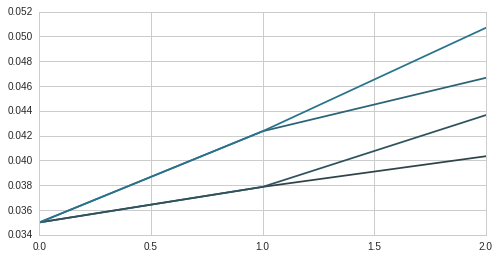

In [55]:
df.plot(legend=False)

In [56]:
import pandas as pd
print "Erro de aproximacao: {:.6f}".format(abs(df.T.mean()-pd.Series([0.035, 0.04, 0.045])).sum())

Erro de aproximacao: 0.000442


In [311]:
import binomial_tree; reload(binomial_tree)
import pandas as pd

l_txindicativa = [14.152, 14.0265, 13.7596, 13.4663, 13.1995,
                  12.9729, 12.8001, 12.7250, 12.6541, 12.5649,
                  12.5653, 12.6005]
l_prazo = [9., 73., 135., 198., 259., 323., 384., 445., 508, 634., 758., 887.]


l_txindicativa = [14.152, 14.0265, 13.7596]
l_txindicativa = [14.152, 14.0265]
l_txindicativa = [x/100. for x in l_txindicativa]
# l_prazo = [9., 73., 135.]

l_prazo = [1., 2.5]
l_prazo = [x*252. for x in l_prazo]


# l_txindicativa = [0.035, 0.04, 0.045]
# l_prazo = [1., 2., 3.]
# l_prazo = [x*252. for x in l_prazo]


my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1)
self = my_tree

df = my_tree.get_lattice()
# print "Erro de aproximacao: {:.6f}".format(abs(df.T.mean()-pd.Series(l_txindicativa)).sum())

In [261]:
df.T.mean()

1.0    0.14152
2.5        NaN
dtype: float64

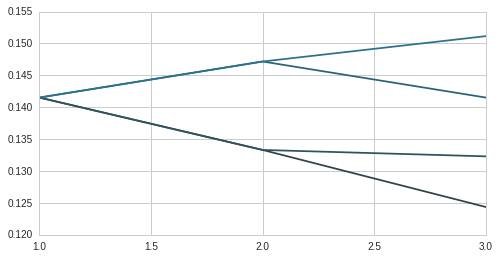

In [152]:
df1 = self.get_lattice()
df1.plot(legend=False)

In [134]:
df1

,0,1,2,3
0,0.141520,0.141520,0.141520,0.141520
1,0.160224,0.160224,0.196170,0.196170
2,0.172232,0.192855,0.217367,0.244218


In [109]:
df.T

,0,1,2
0,0.035,0.037864,0.040335
1,0.035,0.037864,0.043652
2,0.035,0.042351,0.046658
3,0.035,0.042351,0.050692


In [310]:
my_tree.get_description()

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       14.03       nan-2438847320.062    1.0000
U       14.03       nan-2978814843.455    1.0000
DD      21.76   100.000     0.000    1.5000
DU      21.76   100.000     0.000    1.5000
UU      21.76   100.000     0.000    1.5000


In [193]:
i_step = 2

In [254]:
my_tree['D'].f_r = 0.1251527519
my_tree['U'].f_r = 0.1528619165

In [255]:
f_initial_rate = self.l_short_rates[i_step]
f_face_value = self.f_face_value

In [263]:
self = my_tree

In [264]:
f_rate = f_initial_rate
print f_rate

0.137596


In [290]:
# preenche taxas do passo atual
f_face_value = self.f_face_value
for node in self.d_step[i_step]:
    node.f_r = self._get_short_rate(f_rate, node)

In [291]:
i_step = 1

In [292]:
self.get_description()

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       14.03       nan    14.027    1.0000
U       14.03       nan    17.132    1.0000
DD      21.76   100.000    13.760    1.5000
DU      21.76   100.000    16.806    1.5000
UU      21.76   100.000    20.527    1.5000


In [312]:
f_rate = 0.140265

In [321]:
# preenche taxas do passo atual
f_face_value = self.f_face_value
for node in self.d_step[i_step]:
    node.f_r = self._get_short_rate(f_rate, node)

In [314]:
self.get_description()

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       14.03       nan    14.027    1.0000
U       14.03       nan    17.132    1.0000
DD      21.76   100.000     0.000    1.5000
DU      21.76   100.000     0.000    1.5000
UU      21.76   100.000     0.000    1.5000


In [315]:
f_initial_rate = f_rate

In [323]:
f_rate = 0.12515

In [324]:
for i_aux_step in xrange(i_step, -1, -1):
    for node in self.d_step[i_aux_step]:
        f_cupon = f_face_value * ((1+f_initial_rate)**node.f_time-1)
        s_down, s_up = node.get_childrens()
        node_down = self[s_down]
        node_up = self[s_up]
        f_aux = (node_down.f_value + node_down.f_cupon)
        f_aux *= node_down.f_prob
        f_aux += (node_up.f_value + node_up.f_cupon) * node_up.f_prob
        f_aux /= (1+node.f_r)**(node_down.f_time)
#         if node.name=='D':
#             break
        node.set_values(f_cupon=f_cupon,
                        f_value=f_aux)
        print "{}: {}, {} = {:.3f}".format(node, node_down, node_up, f_aux)



D: DD, DU = 2.451
U: DU, UU = 1.853
_: D, U = 14.172


In [325]:
self.get_description()


        cupon     valor     taxa      prazo     
_        0.00    14.172    14.152    1.0000
D       14.03     2.451  1251.500    1.0000
U       14.03     1.853  1528.586    1.0000
DD      21.76   100.000     0.000    1.5000
DU      21.76   100.000     0.000    1.5000
UU      21.76   100.000     0.000    1.5000


In [288]:
self._go_backward(i_step)

In [302]:
# preenche valores no passo posterior
f_initial_rate = self.l_short_rates[i_step]
f_face_value = self.f_face_value

for node in self.d_step[i_step+1]:
    f_cupon = f_face_value * ((1+f_initial_rate)**node.f_time-1)
    node.set_values(f_cupon=f_cupon,
                    f_value=f_face_value)

In [305]:
from scipy import optimize

In [306]:
optimize.minimize?

In [318]:
    res = optimize.minimize(self._set_all_values,
                            f_initial_rate * 1000,
                            args=(f_initial_rate, i_step, True),
                           )

[ 0.140265]
[ 0.00014027]
[ 0.00014027]
[-23816868.35997907]
[-23816868.35997907]
[-23816.86835998]
[ -1.19084342e+08]
[ -1.19084342e+08]
[-119084.3417999]
[ -5.00154236e+08]
[ -5.00154236e+08]
[-500154.23555956]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e+09]
[-1190843.41799896]
[ -1.19084342e+09]
[ -1.19084342e

In [308]:
self.get_description()

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       14.03       nan-46517590.521    1.0000
U       14.03       nan-56816713.365    1.0000
DD      21.76   100.000    13.760    1.5000
DU      21.76   100.000    16.806    1.5000
UU      21.76   100.000    20.527    1.5000


In [301]:
f_initial_rate

0.140265

In [244]:
node

D

In [247]:
(node_down.f_value + node_down.f_cupon)

121.33387968022306

In [251]:
        f_aux = (node_down.f_value + node_down.f_cupon)
        f_aux *= node_down.f_prob
        f_aux += (node_up.f_value + node_up.f_cupon) * node_up.f_prob

In [253]:
node.f_r

0.1528619165

In [250]:
(node_up.f_value + node_up.f_cupon)

120.02121606815004

In [289]:
self.get_description()

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       14.03       nan-46517590.521    1.0000
U       14.03       nan-56816713.365    1.0000
DD      21.76   100.000    13.760    1.5000
DU      21.76   100.000    16.806    1.5000
UU      21.76   100.000    20.527    1.5000


In [201]:
        # preenche taxas do passo atual
        f_face_value = self.f_face_value
        for node in self.d_step[i_step]:
            node.f_r = self._get_short_rate(f_rate, node)
        # itera toda a arvore. Eh esperado que nos anteriores jah
        # tenham a taxa setada
        for i_aux_step in xrange(i_step, -1, -1):
            for node in self.d_step[i_aux_step]:
                # calcula cupon usando taxa atual
                f_cupon = f_face_value * ((1+f_initial_rate)**node.f_time-1)
                # calcula valor presente pegabdo valores dos childrens
                s_down, s_up = node.get_childrens()
                node_down = self[s_down]
                node_up = self[s_up]
                f_aux = (node_down.f_value + node_down.f_cupon)
                f_aux *= node_down.f_prob
                f_aux += (node_up.f_value + node_up.f_cupon) * node_up.f_prob
                f_aux /= (1+node.f_r)**(node_down.f_time)
                node.set_values(f_cupon=f_cupon,
                                f_value=f_aux)

AttributeError: 'float' object has no attribute 'f_value'

In [204]:
i_step

3

In [203]:
i_aux_step

3

In [202]:
node

DDD

In [190]:
node.f_time

1.5

In [ ]:
f_rate = 

In [189]:
self._get_short_rate(f_rate, node)

0.17578661234413762

In [187]:
node = self['DU']

In [198]:
print "     {:3}{:10}{:10}{:10}{:10}".format('', 'cupon','valor','taxa','prazo')
for i_step in self.d_step.keys():
    for node in self.d_step[i_step]:
        f_val = float(node.f_value)
        if not f_val:
            f_val = 0
        f_val1 = float(node.f_r)
        if not f_val1:
            f_val1 = 0
        print "{:3}{:10.2f}{:10.3f}{:10.3f}{:10.4f}".format(node.name,
                                                                    node.f_cupon,
                                                                    f_val,
                                                                    f_val1 * 100,
                                                                    node.f_time)

        cupon     valor     taxa      prazo     
_        0.00       nan    14.152    1.0000
D       13.76       nan    15.286    1.0000
U       13.76       nan    12.515    1.0000
DD      21.33   100.000    13.760    1.5000
DU      21.33    98.687    16.806    1.5000
UU      21.33    97.152    20.527    1.5000
DDD      6.66   100.000     0.000    0.5000
DDU      6.66   100.000     0.000    0.5000
DUU      6.66   100.000     0.000    0.5000
UUU      6.66   100.000     0.000    0.5000


In [282]:
f_val1

0.0004458992017760612

In [202]:
l_nodes

[DD, DU, UU]

In [184]:
for node in self.d_step[i_step+1]:
    f_cupon = f_face_value * (((1+f_r_step)**node.f_time)-1)
    node.set_values(f_cupon=f_cupon,
                    f_value=f_face_value)

In [185]:
node.f_cupon

3.389792086309673

In [186]:
f_initial_rate

0.140265

In [188]:
f_initial_rate

0.140265

In [189]:
self.f_face_value

100.0

In [190]:
self['_'].f_value

array([ nan])

In [191]:
self._set_all_values(f_initial_rate, i_step)

16.501019531845827

In [193]:
res**0.5

38.26911210512003

In [87]:
[x/100. for x in l_txindicativa]

[0.14151999999999998, 0.140265, 0.137596]

In [88]:
node = my_tree['U']

In [89]:
node.i_step

1

In [90]:
my_tree._get_short_rate(l_txindicativa[1]/100, node)

0.17132005787333623

In [58]:
i_step = 0
self = my_tree

f_initial_rate = self.l_short_rates[i_step]
f_face_value = self.f_face_value
f_r_step = self.l_short_rates[i_step]
for node in self.d_step[i_step+1]:
    f_cupon = f_face_value * (((1+f_r_step)**node.f_time)-1)

In [59]:
f_cupon

4.738358815740362

In [63]:
my_tree['DD'].f_cupon

140.26500000000001

In [57]:
(((1+f_r_step)**node.f_time)-1)

0.03389792086309673

In [54]:
f_r_step

0.140265

In [55]:
f_cupon

33.89792086309673

In [39]:
my_tree['D'].f_r

array([-3811.63173898])

In [14]:
import pandas as pd

In [28]:
df = pd.DataFrame(l_txindicativa)
df.index = [x/252. for x in l_prazo]

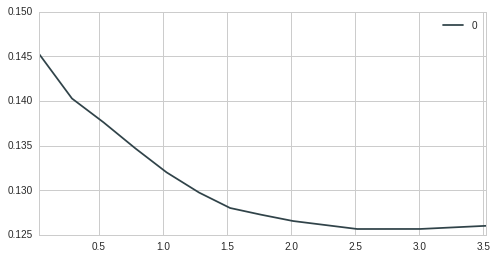

In [30]:
df.plot()

In [355]:
import numpy as np

In [359]:
list(np.arange(0.035, 0.1))

[0.035000000000000003]

In [385]:
def foo():
    l_rates = list(np.linspace(0.035, 0.12, 100))
    l_mat = list(np.arange(1., len(l_rates)+1))
    x = binomial_tree.KWFTree(l_rates, l_mat)
    x.fit_foward_curve(0.1)
    df = x.get_lattice()
    return df

%time df = foo()

CPU times: user 36.4 s, sys: 187 ms, total: 36.6 s
Wall time: 36.6 s


In [389]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
95,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.148062,0.148062,...,712.019198,712.019198,831.302867,831.302867,971.339544,971.339544,1136.247253,1136.247253,1330.964444,1330.964444
96,0.147472,0.147472,0.147472,0.147472,0.147472,0.147472,0.147744,0.147744,0.148338,0.148338,...,786.914906,786.914906,919.157896,919.157896,1074.469540,1074.469540,1257.430117,1257.430117,1473.533642,1473.533642
97,0.147170,0.147170,0.147170,0.147170,0.147441,0.147441,0.148033,0.148033,0.149005,0.149005,...,869.744506,869.744506,1016.354983,1016.354983,1188.606718,1188.606718,1391.593865,1391.593865,inf,inf
98,0.146883,0.146883,0.147153,0.147153,0.147743,0.147743,0.148711,0.148711,0.150123,0.150123,...,961.352682,961.352682,1123.891805,1123.891805,inf,inf,inf,inf,inf,inf
99,0.146611,0.146880,0.147148,0.147468,0.148052,0.148431,0.149390,0.149838,0.151237,0.151763,...,1060.549118,1062.674340,inf,inf,inf,inf,inf,inf,inf,inf


In [396]:
df.tail(1).T.tail(15)

,99
183,660.575320
184,774.974345
185,776.527847
186,906.993742
187,908.811547
188,1060.549118
189,1062.674340
190,inf
191,inf
192,inf


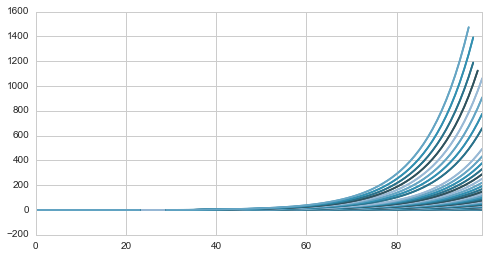

In [387]:
df.plot(legend=False)

In [388]:
df.shape

(100, 198)

#### TODO:
- Apresentar os principais pontos da abordagem (hipóteses, limitações e etc)
- Implementar
- detalhar o processo de calibração (juros e vol)
- Detalhar a determiação dos parâmetros do modelo ($\sigma$)
- Checar se tem base de dados de opções (Call Européia) de Juros
- Levantar os preços histórico dos títulos: NTB...
- Demonstrar a precificação de 2 derivativos mais complexos (opcional compara com mercado)


In [1]:
[1, 2, 3, 4, 5]

[1, 2, 3, 4, 5]

In [ ]:
{1: [1], 2:[2, 2], 3:[3, 3, 3]}

In [ ]:
class kwf_model(object):
    '''
    '''
    def __init__(self, l_prices, l_maturity, f_sigma, ll_cupon=[])
        '''
        Implements the kwf model
        :param l_prices: list. Market Prices
        :param l_maturity: list. The maturirity in year of the contracts
        :param f_sigma. float. The volatility of the 
        :*ll_cupon: list of lists. The cupons of each instrument
        '''
        self.l_prices = l_prices
        self.l_maturity = l_maturity
        self.f_sigma = f_sigma
        sefl.ll_cupon = ll_cupon
        self.d_forward = self.fit_curve()

    def fit_curve(self):
        '''
        Return the forwards that fit the market curve
        '''
        raise NotImplementedError()
        return d_rtn

    
class Bond(object):
    '''
    '''
    def __init__(self, f_cupon, f_face_value):
        '''
        '''
        raise NotImplementedError()

    def get_value(self, o_kwf_model):
        '''
        '''
        raise NotImplementedError()
        return f_rtn


In [ ]:
l_prices = [0.035, 0.04, 0.045]
l_maturity = [1., 2., 3.]
f_sigma = 0.1


my_curve = kwf_model(l_prices, l_maturity, f_sigma)

In [ ]:
mybond = Bond(0.045, 100.)
mybond.get_value(my_curve)  # retorna preco

## 2. Bla

bla bla

### 2.1. Bla

bla bla

## 3. Conclusão

bla bla

## 4. Últimas Considerações

bla bla

*Style notebook and change matplotlib defaults*

In [11]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [12]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))